# Exploratory Data Analysis
In this notebook, we explore and visualize the structure of the dataset. To run the code, both the kernel and the vector representations of the IMDB dataset must be present in "kernels/without_labels".

In [1]:
import os
import numpy as np
from auxiliarymethods import datasets as dp
from auxiliarymethods.reader import tud_to_networkx
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD
from matplotlib import pyplot as plt
#from nrkmeans import NrKmeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
from scipy.sparse import load_npz
import auxiliarymethods.auxiliary_methods as aux
import networkx as nx
from sklearn.cluster import KMeans
from copy import deepcopy
import collections

In [2]:
# utility functions
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

In [3]:
base_path = os.path.join("kernels", "without_labels")
ds_name = "IMDB-BINARY"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)

In [4]:
def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show();

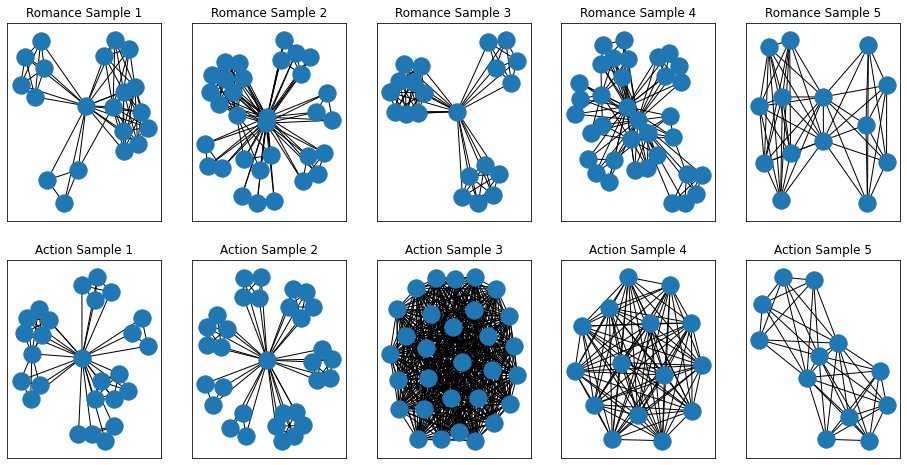

In [5]:
# Draw 5 Ego-graphs for each class
fig, axs = plt.subplots(2,5,figsize=(16,8))

for idx in range(5):
    nx.draw_networkx(G[idx], 
                     pos=nx.spring_layout(G[idx], seed=42),
                     ax = axs[0,idx],
                     with_labels = False,
                     cmap="Set2")
    axs[0,idx].set_title(f"Romance Sample {idx+1}")
for idx in range(5):
    nx.draw_networkx(G[-idx-1], 
                     pos=nx.spring_layout(G[-idx-1], seed=42),
                     ax = axs[1,idx],
                     with_labels = False,
                     cmap="Set2")
    axs[1,idx].set_title(f"Action Sample {idx+1}")

# Looking at a small sample of Ego-graphs

This small sample shows us there are not obvious qualitative differences to a human, when looking at the shape of the graphs. There are actors in both genres with sparse, dense, big and small graphs, which indicates this problem may be difficult to solve.

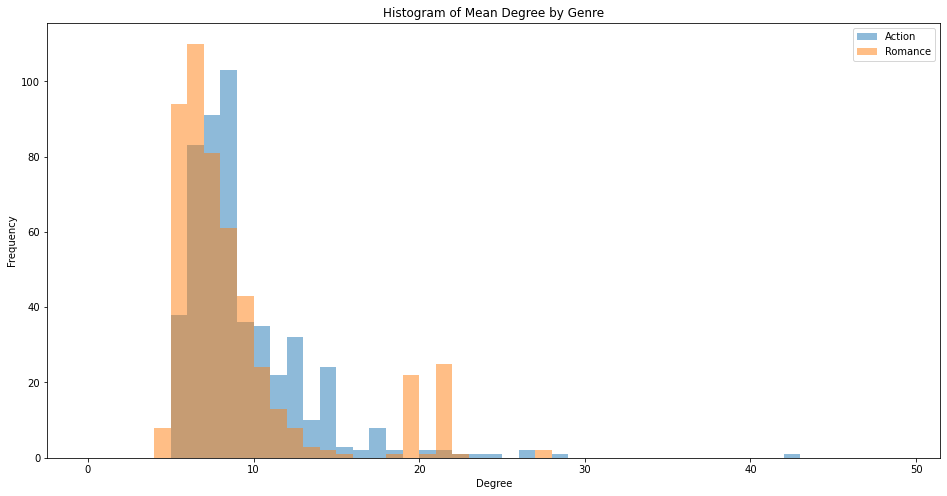

In [6]:
degree_sequence = [np.mean(G[i].degree()) for i in range(len(classes))]
fig, axs = plt.subplots(1,1,figsize=(16,8))

degs = degree_sequence[:500]
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Degree by Genre")
plt.hist(degs,alpha=0.5,label="Action",bins=range(50))

degs = degree_sequence[500:]
plt.hist(degs,alpha=0.5,label="Romance",bins=range(50))
plt.legend()

plt.show()

# Comparing Genres by Mean Degree

Each set of graphs has a similar distribution, but action is marginally shifted to the right, indicating that there are more shared films between actors on average. This indicates it may be hard to separate out the genres with purely unsupervised techniques.

In [7]:
# Determine how much lowering the dimension changes the output of the K means algorithm

best_combination = None
best_nmi = 0

components =  [1,2,5,10,20,50,100,200,500]
results = np.zeros((len(components),7))
cluster_centres = np.zeros((len(components),7,2,2))
for i,n_components in enumerate(components):
    for iterations in range(1,6):
        #Gram Matrix for the Weisfeiler-Lehman subtree kernel
        gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_wl{iterations}.csv"))
        gram = aux.normalize_gram_matrix(gram)

        kpca = KernelPCA(n_components=n_components, kernel="precomputed")
        reduced_kpca = kpca.fit_transform(gram)

        kmeans = KMeans(n_clusters=2)
        kmeans.fit(reduced_kpca)

        nmi = normalized_mutual_info_score(kmeans.labels_,classes)
        results[i,iterations-1] = nmi
        
        if n_components > 1:
            cluster_centres[i,iterations-1,:] = kmeans.cluster_centers_[:,:2]
        
        if nmi > best_nmi:
            best_nmi = nmi
            best_combination = [n_components,f"wl{iterations}",reduced_kpca]
            best_kmeans = kmeans

        print("PCA components:",n_components,"Weisfeiler-Lehman",iterations,nmi,np.mean(kmeans.labels_))

    for j,kernel_name in enumerate(["graphlet","shortestpath"]):
        gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_{kernel_name}.csv"))
        gram = aux.normalize_gram_matrix(gram)

        kpca = KernelPCA(n_components=n_components, kernel="precomputed")
        reduced_kpca = kpca.fit_transform(gram)

        kmeans = KMeans(n_clusters=2)
        kmeans.fit(reduced_kpca)

        nmi = normalized_mutual_info_score(kmeans.labels_,classes)
        results[i,5+j] = nmi
        if n_components > 1:
            cluster_centres[i,5+j,:] = kmeans.cluster_centers_[:,:2]
        
        if nmi > best_nmi:
            best_nmi = nmi
            best_combination = [n_components,kernel_name,reduced_kpca]
            best_kmeans = kmeans


        print("PCA components:",n_components,kernel_name,nmi,np.mean(kmeans.labels_))
        
print(best_combination,best_nmi)


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 1 Weisfeiler-Lehman 1 0.04299776356741198 0.415


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 1 Weisfeiler-Lehman 2 0.03527961979833594 0.52


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 1 Weisfeiler-Lehman 3 0.033448918500398814 0.381


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 1 Weisfeiler-Lehman 4 0.02389012035992634 0.952


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 1 Weisfeiler-Lehman 5 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 1 graphlet 0.0220538793608341 0.471


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 1 shortestpath 0.015245453739296064 0.782


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 2 Weisfeiler-Lehman 1 0.044920504923674394 0.578


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 2 Weisfeiler-Lehman 2 0.0391642524699292 0.422


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 2 Weisfeiler-Lehman 3 0.03420045229158934 0.569


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 2 Weisfeiler-Lehman 4 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 2 Weisfeiler-Lehman 5 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 2 graphlet 0.022559351697335632 0.472


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 2 shortestpath 0.014294135144511505 0.216


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 5 Weisfeiler-Lehman 1 0.05771513251974923 0.561


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 5 Weisfeiler-Lehman 2 0.05596471434095307 0.441


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 5 Weisfeiler-Lehman 3 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 5 Weisfeiler-Lehman 4 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 5 Weisfeiler-Lehman 5 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 5 graphlet 0.022559351697335632 0.528


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 5 shortestpath 0.014294135144511505 0.784


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 10 Weisfeiler-Lehman 1 0.05691636152052312 0.562


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 10 Weisfeiler-Lehman 2 0.04813101909805827 0.418


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 10 Weisfeiler-Lehman 3 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 10 Weisfeiler-Lehman 4 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 10 Weisfeiler-Lehman 5 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 10 graphlet 0.022559351697335632 0.528


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 10 shortestpath 0.014294135144511505 0.216


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 20 Weisfeiler-Lehman 1 0.05771513251974923 0.439


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 20 Weisfeiler-Lehman 2 0.05691636152052312 0.562


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 20 Weisfeiler-Lehman 3 0.02389012035992634 0.952


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 20 Weisfeiler-Lehman 4 0.02389012035992634 0.952


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 20 Weisfeiler-Lehman 5 0.05588952106085696 0.443


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 20 graphlet 0.022559351697335632 0.472


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 20 shortestpath 0.014294135144511505 0.216


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 50 Weisfeiler-Lehman 1 0.05691636152052312 0.438


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 50 Weisfeiler-Lehman 2 0.05691636152052312 0.562


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 50 Weisfeiler-Lehman 3 0.02389012035992634 0.952


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 50 Weisfeiler-Lehman 4 0.02389012035992634 0.952


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 50 Weisfeiler-Lehman 5 0.02389012035992634 0.952


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 50 graphlet 0.022559351697335632 0.472


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 50 shortestpath 0.014294135144511505 0.216


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 100 Weisfeiler-Lehman 1 0.05771513251974923 0.439


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 100 Weisfeiler-Lehman 2 0.04231211340616508 0.414


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 100 Weisfeiler-Lehman 3 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 100 Weisfeiler-Lehman 4 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 100 Weisfeiler-Lehman 5 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 100 graphlet 0.022559351697335632 0.472


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 100 shortestpath 0.014294135144511505 0.784


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 200 Weisfeiler-Lehman 1 0.05771513251974923 0.561


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 200 Weisfeiler-Lehman 2 0.05691636152052312 0.438


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 200 Weisfeiler-Lehman 3 0.05578312793051556 0.574


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 200 Weisfeiler-Lehman 4 0.04707277189003567 0.592


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 200 Weisfeiler-Lehman 5 0.00021201004056983097 0.024


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 200 graphlet 0.022559351697335632 0.472


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 200 shortestpath 0.014294135144511505 0.216


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 500 Weisfeiler-Lehman 1 0.05771513251974923 0.439


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 500 Weisfeiler-Lehman 2 0.05691636152052312 0.438


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 500 Weisfeiler-Lehman 3 0.053863540033816326 0.568


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 500 Weisfeiler-Lehman 4 0.012633711681308684 0.072


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 500 Weisfeiler-Lehman 5 0.02389012035992634 0.048


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 500 graphlet 0.022559351697335632 0.528


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


PCA components: 500 shortestpath 0.014294135144511505 0.784
[5, 'wl1', array([[ 0.26501274, -0.19959762,  0.0641755 , -0.18782083, -0.15054057],
       [ 0.36478591, -0.11758552, -0.1914317 ,  0.22941976,  0.04356684],
       [ 0.2135772 , -0.15716397,  0.29347112, -0.07316116, -0.21311222],
       ...,
       [-0.29086658, -0.26401822, -0.0913232 , -0.06846675, -0.15033894],
       [ 0.62584803, -0.02564405, -0.10528333, -0.21461956, -0.00381966],
       [ 0.42671305, -0.11426264, -0.26741178,  0.46047197,  0.17747998]])] 0.05771513251974923


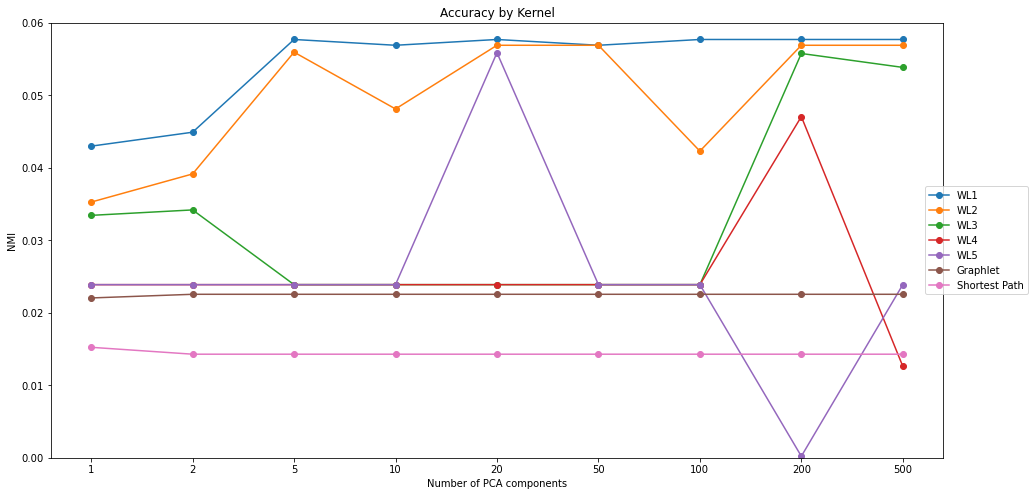

In [8]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_ylabel("NMI")
ax.set_xlabel("Number of PCA components")
ax.set_ylim([0.0,0.06])
ax.set_xticks([i for i in range(len(components))])
ax.set_xticklabels(components)
kernels = ["WL1","WL2","WL3","WL4","WL5","Graphlet","Shortest Path"]
ax.set_title("Accuracy by Kernel")
for i in range(7):
    ax.plot(results[:,i],marker="o",label=kernels[i])
ax.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.show()

# Number of PCA Components:

The number of PCA components does not change the NMI with the ground truth labels very much at all. The ranking of performance remains the same as you change the number of components. Graphlet and Shortest Path clearly don't line up much with the genre.

From now on will use 10 PCA Components for the analysis with K means, for speed purposes, without sacrificing much "accuracy".

# Comparing Kernels

K means on different kernels results in quite different clusterings. 

In [15]:
labels = []
kmeans_list = []
data_list = []


for iterations in range(1,6):
    #Gram Matrix for the Weisfeiler-Lehman subtree kernel
    print(f"wl{iterations}")
    gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_wl{iterations}.csv"))
    gram = aux.normalize_gram_matrix(gram)

    kpca = KernelPCA(n_components=10, kernel="precomputed")
    reduced_kpca = kpca.fit_transform(gram)    
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(reduced_kpca)
    
    kmeans_list.append(kmeans)
    labels.append(kmeans.labels_)
    data_list.append(reduced_kpca)

for j,kernel_name in enumerate(["graphlet","shortestpath"]):
    print(kernel_name)
    gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_{kernel_name}.csv"))
    gram = aux.normalize_gram_matrix(gram)

    kpca = KernelPCA(n_components=10, kernel="precomputed")
    reduced_kpca = kpca.fit_transform(gram)

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(reduced_kpca)

    kmeans_list.append(kmeans)
    labels.append(kmeans.labels_)
    data_list.append(reduced_kpca)
    


wl1
wl2
wl3
wl4
wl5
graphlet
shortestpath


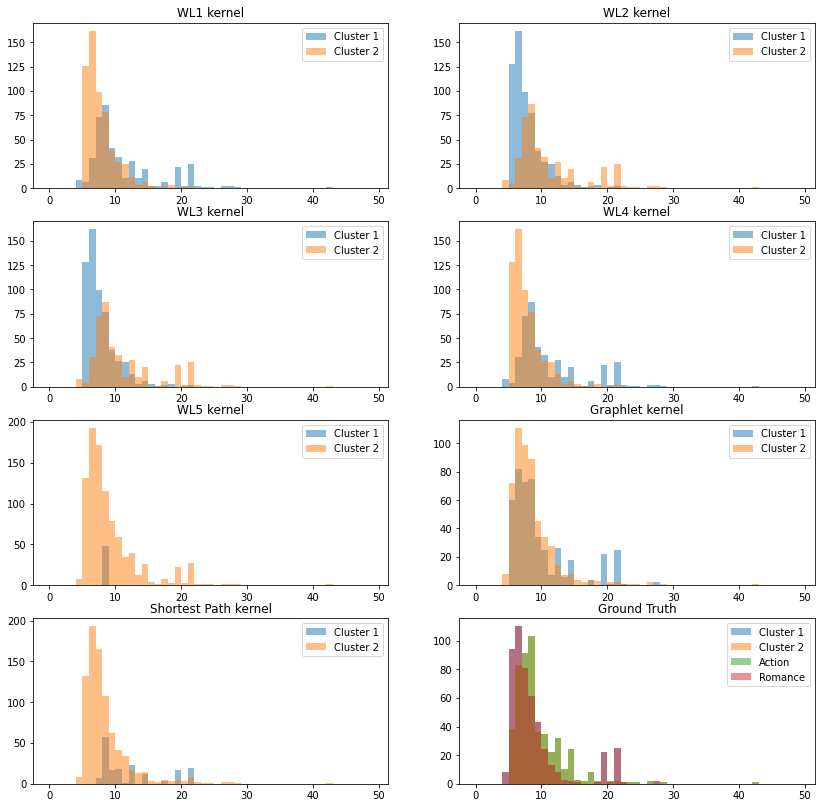

In [13]:
    
fig, axs = plt.subplots(4,2,figsize=(14,14))
ks = ["WL1","WL2","WL3","WL4","WL5","Graphlet","Shortest Path","Ground Truth"]

for j,labs in enumerate(labels):
    cluster1_graphs = [g for i,g in enumerate(G) if labs[i] == 1]
    cluster2_graphs = [g for i,g in enumerate(G) if labs[i] == 0]

    degs = [np.mean(cluster1_graphs[i].degree()) for i in range(len(cluster1_graphs))]
    #axs[j].set_xlabel("Degree")
    #axs[j%2,j//4].set_ylabel("Frequency")
    axs[j//2,j%2].set_title(f"{ks[j]} kernel")
    axs[j//2,j%2].hist(degs,alpha=0.5,label="Cluster 1",bins=range(50))

    degs = [np.mean(cluster2_graphs[i].degree()) for i in range(len(cluster2_graphs))]
    axs[j//2,j%2].hist(degs,alpha=0.5,label="Cluster 2",bins=range(50))
    axs[j//2,j%2].legend()
    
degree_sequence = [np.mean(G[i].degree()) for i in range(len(classes))]

degs = degree_sequence[:500]
axs[3,1].hist(degs,alpha=0.5,label="Action",bins=range(50))
axs[3,1].set_title(f"Ground Truth")

degs = degree_sequence[500:]
axs[3,1].hist(degs,alpha=0.5,label="Romance",bins=range(50))
axs[3,1].legend()

plt.show()


number of data points in cluster 0: 561
number of data points in cluster 1: 439
number of data points in cluster 0: 562
number of data points in cluster 1: 438
number of data points in cluster 0: 558
number of data points in cluster 1: 442
number of data points in cluster 0: 952
number of data points in cluster 1: 48
number of data points in cluster 0: 952
number of data points in cluster 1: 48
number of data points in cluster 0: 472
number of data points in cluster 1: 528
number of data points in cluster 0: 784
number of data points in cluster 1: 216


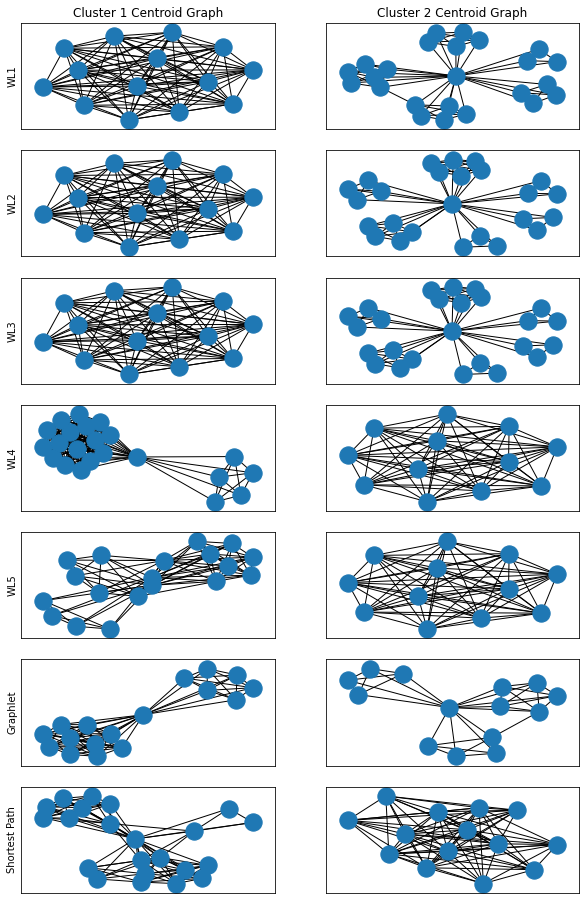

In [17]:
from sklearn.metrics import pairwise_distances

# Draw 5 Ego-graphs for each class
fig, axs = plt.subplots(7,2,figsize=(10,16))

# select nearest neighbours in for each cluster
nr_nearest = 1
nearest_indices = []
for j,labs in enumerate(labels):
    for cluster_i in [0,1]:
        graphs = [g for i,g in enumerate(G) if labs[i] == cluster_i]
        print(f"number of data points in cluster {cluster_i}: {len(graphs)}")
        center_i = kmeans_list[j].cluster_centers_[cluster_i].reshape(1,-1)
        data = data_list[j]
        distances_i = pairwise_distances(center_i, data)
        nearest_index = np.argsort(distances_i, )[0][0]
        nx.draw_networkx(G[nearest_index], 
                         pos=nx.spring_layout(G[nearest_index], seed=42),
                         ax = axs[j,cluster_i],
                         with_labels = False,
                         cmap="Set2")
        
    axs[j,0].set_ylabel(ks[j])
axs[0,0].set_title("Cluster 1 Centroid Graph")
axs[0,1].set_title("Cluster 2 Centroid Graph")
plt.show()

# Results

In general, the WL kernels pick a graph which is fully connected as one cluster centroid, and one which is sparsely connected as another. This makes sense as with any number of iterations of a WL kernel, a fully connected graph does not change.

The Graphlet kernel picks two cluster centroids where the graphlets look similar.

The Shortest Path kernel has one cluster centroid with short paths, and one with longer paths on average.

In [11]:
#NMI between different kernels

labels = []
results = np.zeros((8,8))

for iterations in range(1,6):
    #Gram Matrix for the Weisfeiler-Lehman subtree kernel
    
    gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_wl{iterations}.csv"))
    gram = aux.normalize_gram_matrix(gram)
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(gram)
    labels.append(kmeans.labels_)
    print(iterations)

for j,kernel_name in enumerate(["graphlet","shortestpath"]):
    gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_{kernel_name}.csv"))
    gram = aux.normalize_gram_matrix(gram)

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(gram)

    labels.append(kmeans.labels_)
    
labels.append(classes)
    
for i,l1 in enumerate(labels):
    for j,l2 in enumerate(labels):
        results[i,j] = normalized_mutual_info_score(l1,l2)


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


1


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


2


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


3


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


4


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


5


C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


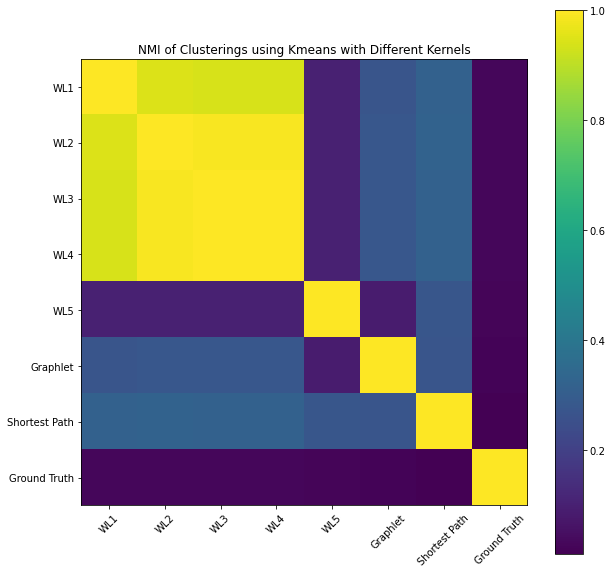

In [12]:
plt.figure(figsize=(10,10))

plt.xticks(range(8),["WL1","WL2","WL3","WL4","WL5","Graphlet","Shortest Path","Ground Truth"], rotation = 45)
plt.yticks(range(8),["WL1","WL2","WL3","WL4","WL5","Graphlet","Shortest Path","Ground Truth"])
plt.title("NMI of Clusterings using Kmeans with Different Kernels")
plt.imshow(results)
plt.colorbar()

# NMI between different Kernels K-means clusterings

WL1, WL2 and WL3 have very similar clusterings, and then so do WL4 and WL5. Graphlet and Shortest Path are not similar to each other or the WL kernels. 

However the most important finding is that none of the kernel clusterings match up well at all with the ground truth labelings. This indicates that the ground truth labelings are not very related to the graph structure itself, and perhaps more node or edge labellings would be important.

# DBSCAN
ERiC is a density-based clustering based on DBSCAN, so it would be interesting whether there are similarities between the results of ERiC and vanilla DBSCAN. Since DBSCAN labels points for which no cluster assignments are found as noise, it can also be used for outlier detection.



In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [7]:
base_path = os.path.join("kernels","without_labels")
ds_name = "IMDB-BINARY"
vec_graphlet = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_graphlet.npz"))
vec_shortestpath = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_shortestpath.npz"))
vec_wl = []
for i in range(1, 6):
  vec_wl.append(load_sparse(os.path.join(base_path,f"{ds_name}_vectors_wl{i}.npz")))

In [8]:
scaler = StandardScaler(with_mean=False)
vec_graphlet = scaler.fit_transform(vec_graphlet)
vec_shortestpath = scaler.fit_transform(vec_shortestpath)

for i in range(5):
  vec_wl[i] = scaler.fit_transform(vec_wl[i])

In [9]:
eps = [0.5, 1, 2, 10]
min_samples = [1, 2, 5]

In [10]:
classes = dp.get_dataset("IMDB-BINARY")

## NMIs and comparison to ground truth labels
We compare the clustering results of different vector representations to each other and to the ground truth labels (action and romance).

In [18]:
columns = ['eps', 'min_samples', 'representation', 'NMI']
dbscan_nmi_df = pd.DataFrame(columns=columns)
nmis = []

for e in eps:
  for m in min_samples:
    clusterings = []
    clustering = DBSCAN(eps=e, min_samples=m, metric='euclidean').fit(vec_graphlet)
    clusterings.append(clustering.labels_)
    nmi = normalized_mutual_info_score(clustering.labels_, classes)
    dbscan_nmi_df = pd.concat([dbscan_nmi_df, pd.DataFrame({'eps':e, 'min_samples':m, 'representation':'graphlet', 'NMI':nmi}, index=columns)], ignore_index=True)

    clustering = DBSCAN(eps=e, min_samples=m, metric='euclidean').fit(vec_shortestpath)
    clusterings.append(clustering.labels_)
    nmi = normalized_mutual_info_score(clustering.labels_, classes)
    dbscan_nmi_df = pd.concat([dbscan_nmi_df, pd.DataFrame({'eps':e, 'min_samples':m, 'representation':'shortestpath', 'NMI':nmi}, index=columns)], ignore_index=True)

    for i in range(1, 6):
      clustering = DBSCAN(eps=e, min_samples=m, metric='euclidean').fit(vec_wl[i-1])
      clusterings.append(clustering.labels_)
      nmi = normalized_mutual_info_score(clustering.labels_, classes)
      dbscan_nmi_df = pd.concat([dbscan_nmi_df, pd.DataFrame({'eps':e, 'min_samples':m, 'representation':f'WL{i}', 'NMI':nmi}, index=columns)], ignore_index=True)

    clusterings.append(classes)
    nmis.append(np.asarray([[normalized_mutual_info_score(c1,c2) for c1 in clusterings] for c2 in clusterings]))

In [21]:
pd.set_option('display.max_rows', 200)
display(dbscan_nmi_df)

,eps,min_samples,representation,NMI
0,0.5,1,graphlet,0.088277
1,0.5,1,graphlet,0.088277
2,0.5,1,graphlet,0.088277
3,0.5,1,graphlet,0.088277
4,0.5,1,shortestpath,0.067257
...,...,...,...,...
331,10.0,5,WL4,0.082382
332,10.0,5,WL5,0.082382
333,10.0,5,WL5,0.082382
334,10.0,5,WL5,0.082382


### NMI comparison for different kernels and parameters
As seen below, neither of the DBSCAN clusterings corresponds strongly to the ground truth labels, with normalized mutual information scores of below 0.15. The clusterings based on the WL2 to WL5 representations are most similar to the ground truth labels. For higher eps, the similarity to the ground truth seems to be lower especially for the graphlet, shortestpath and WL1 representations.

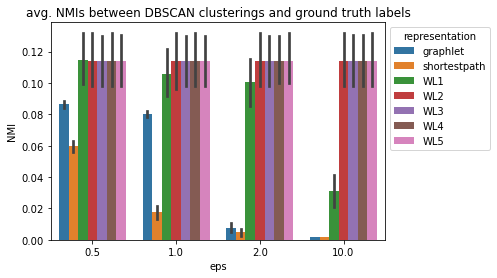

In [22]:
plot1 = sns.barplot(data=dbscan_nmi_df, x="eps", y="NMI", hue="representation")
plot1.set(title='avg. NMIs between DBSCAN clusterings and ground truth labels')
sns.move_legend(plot1, "upper left", bbox_to_anchor=(1, 1))

A higher number of min_samples decreases the normalized mutual information score between the clusterings and the ground truth labels. A higher number of min_samples implies that more points are assigned to the noise instead of a cluster.

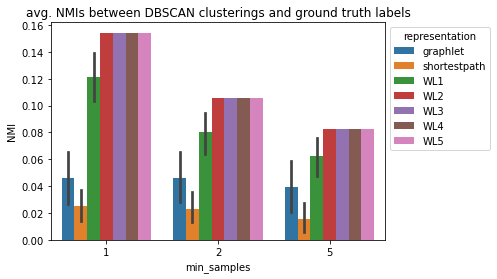

In [23]:
plot2 = sns.barplot(data=dbscan_nmi_df, x="min_samples", y="NMI", hue="representation")
plot2.set(title='avg. NMIs between DBSCAN clusterings and ground truth labels')
sns.move_legend(plot2, "upper left", bbox_to_anchor=(1, 1))

The heatmaps below show the normalized mutual information scores between the different representations. As seen before, WL2 to WL5 reesult in very similar clusterings. The similarity between the shortestpath and graphlet representation seems to depend on the value of eps.

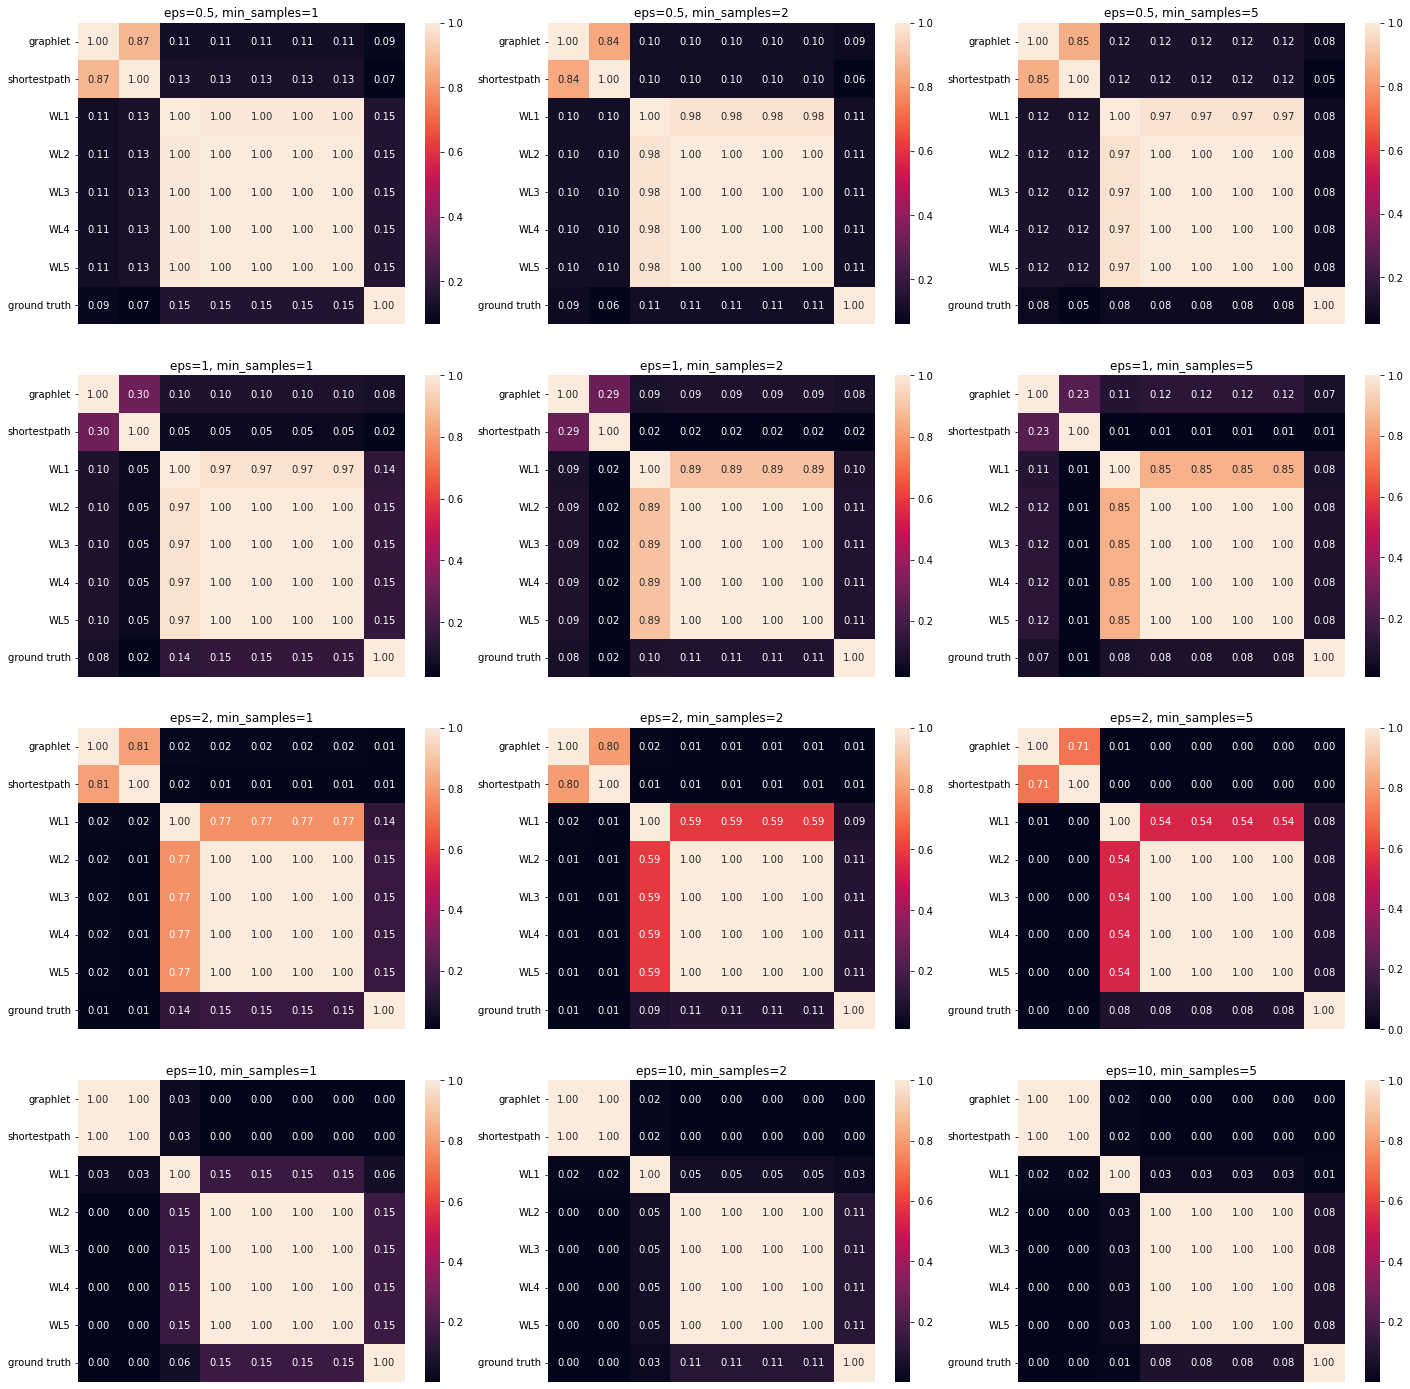

In [24]:
labels = ['graphlet', 'shortestpath'] + [f'WL{i}' for i in range(1, 6)] + ['ground truth']

figure, axes = plt.subplots(len(eps), len(min_samples), figsize=(20, 20))
figure.tight_layout(pad=3)
#figure.suptitle('NMIs between DBSCAN clusterings', fontsize=16)

for i, e in enumerate(eps):
  for j, m in enumerate(min_samples):
    sns.heatmap(ax=axes[i, j], annot=True, fmt='.2f', data=nmis[i*len(min_samples) + j], xticklabels=[], yticklabels=labels).set(title=f'eps={e}, min_samples={m}')

## Outlier detection with DBSCAN

In [43]:
axis1 = 0
axis2 = 1

columns = ['eps', 'min_samples', 'representation', 'clustering', 'outliers', 'kpca_x', 'kpca_y', 'tsvd_x', 'tsvd_y']
representations = ['graphlet']
dbscan_dataframe = pd.DataFrame(columns=columns)
n = vec_graphlet.shape[0]
dbscan_outlier_idx = []

for rep in representations:
  vec = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_{rep}.npz"))
  gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_{rep}.csv"))
  gram = aux.normalize_gram_matrix(gram)
  kpca = KernelPCA(n_components=100, kernel="precomputed")
  reduced_kpca = kpca.fit_transform(gram)
  tsvd = TruncatedSVD(n_components=100)
  reduced_tsvd = tsvd.fit_transform(vec_graphlet)

  for e in eps:
    for m in min_samples:
      clustering = DBSCAN(eps=e, min_samples=m, metric='euclidean').fit(vec_graphlet)
      outliers = np.argwhere(clustering.labels_ == -1)
      dbscan_outlier_idx.append((e, m, outliers))
      print(f"Number of outliers found for eps={e}, min_samples={m}: {len(outliers)}")
      outliers = (clustering.labels_ == -1) * 1
      new_data = list(map(list, zip(*[[e]*n, [m]*n, [rep]*n, clustering.labels_, outliers, reduced_kpca[:,axis1], reduced_kpca[:,axis2], reduced_tsvd[:,axis1], reduced_tsvd[:,axis2]])))
      df = pd.DataFrame(new_data, columns=columns)
      dbscan_dataframe = pd.concat([dbscan_dataframe, df])

Number of outliers found for eps=0.5, min_samples=1: 0
Number of outliers found for eps=0.5, min_samples=2: 7
Number of outliers found for eps=0.5, min_samples=5: 13
Number of outliers found for eps=1, min_samples=1: 0
Number of outliers found for eps=1, min_samples=2: 2
Number of outliers found for eps=1, min_samples=5: 9
Number of outliers found for eps=2, min_samples=1: 0
Number of outliers found for eps=2, min_samples=2: 2
Number of outliers found for eps=2, min_samples=5: 6
Number of outliers found for eps=10, min_samples=1: 0
Number of outliers found for eps=10, min_samples=2: 1
Number of outliers found for eps=10, min_samples=5: 1


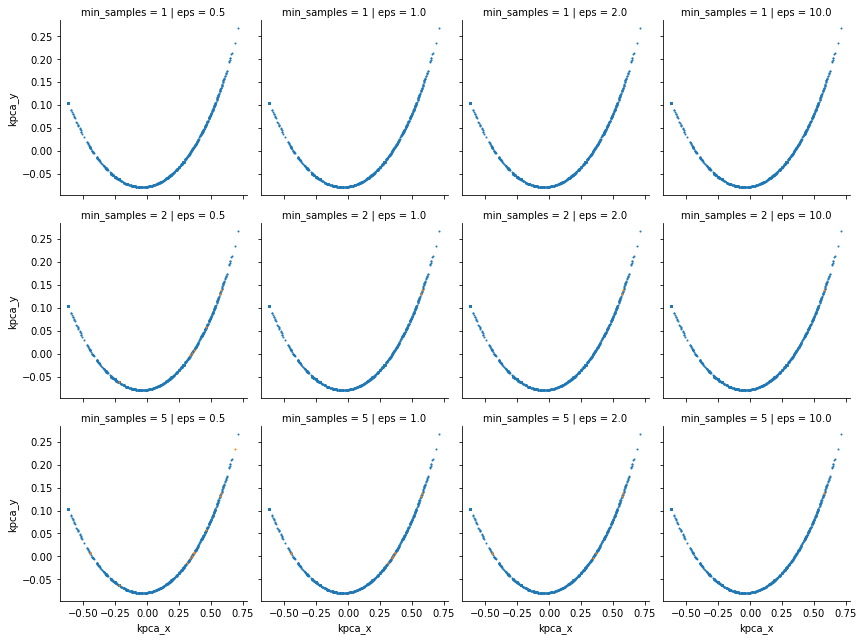

In [45]:
g = sns.FacetGrid(dbscan_dataframe, row = "min_samples", col = "eps", hue = "outliers")
g.set(title='Outliers according to DBSCAN')
g.map(plt.scatter, 'kpca_x', 'kpca_y', s=1)
plt.show()

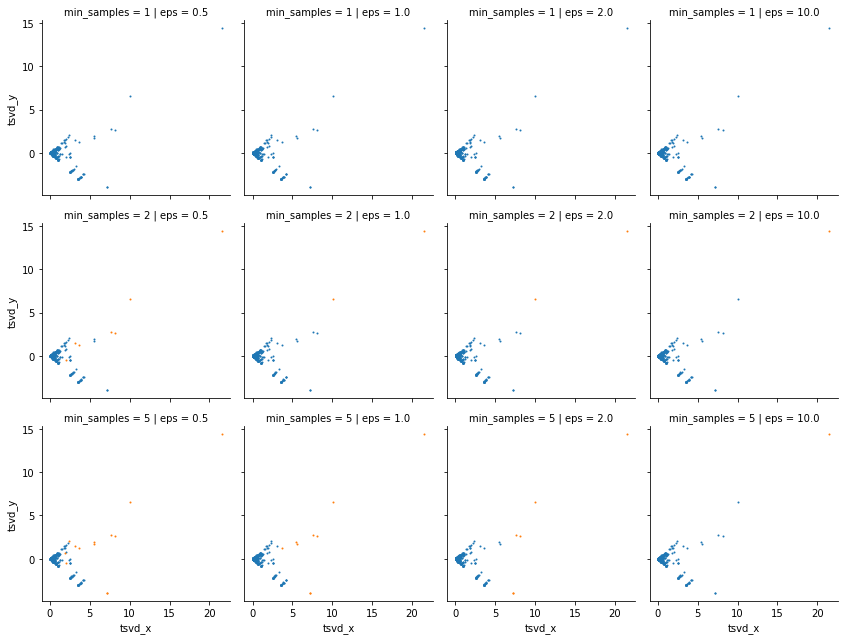

In [46]:
g = sns.FacetGrid(dbscan_dataframe, row = "min_samples", col = "eps", hue = "outliers")
g.map(plt.scatter, 'tsvd_x', 'tsvd_y', s=1)
plt.show()

The orange points in the visualizations represent outliers, while the blue points represent points assigned to clusters. As suspected, setting a number as the parameter for min_samples seems to lead to more noise points.

### Graph visualizations for selected dimensions


DBSCAN outliers for eps=0.5 and min_samples=2:


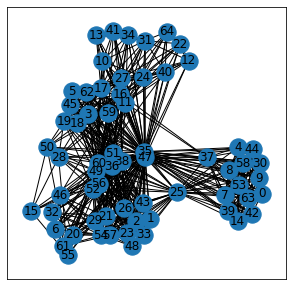

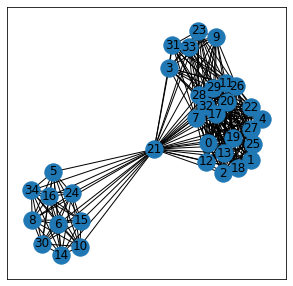

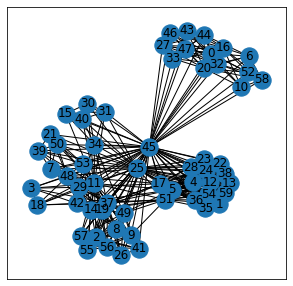

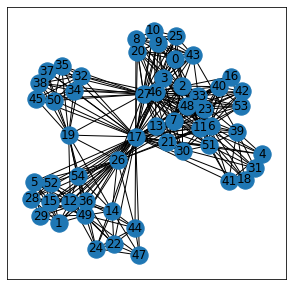

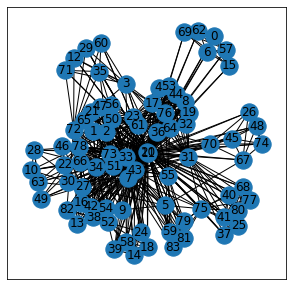

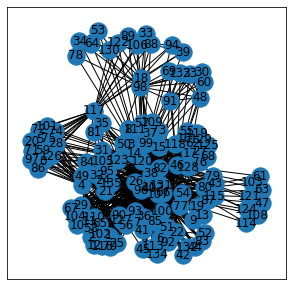

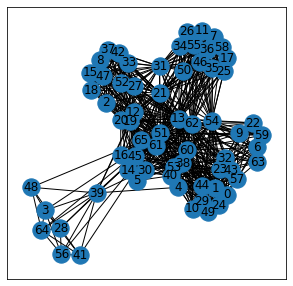

DBSCAN outliers for eps=1 and min_samples=2:


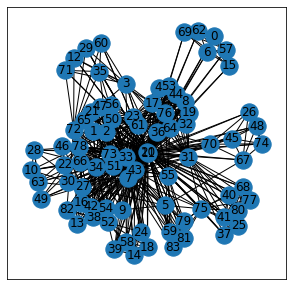

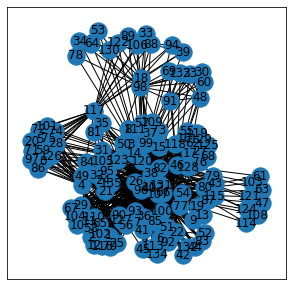

DBSCAN outliers for eps=2 and min_samples=2:


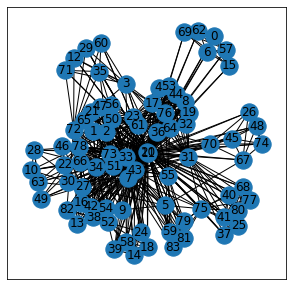

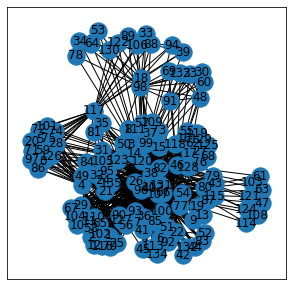

DBSCAN outliers for eps=2 and min_samples=5:


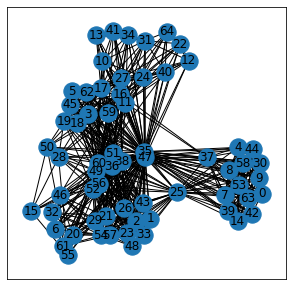

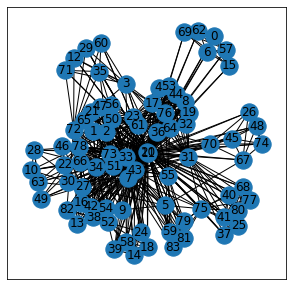

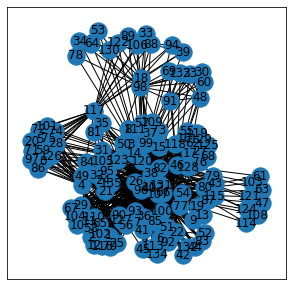

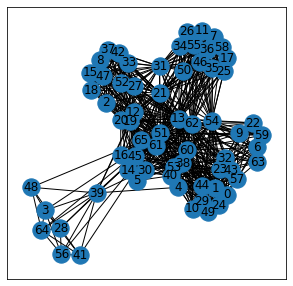

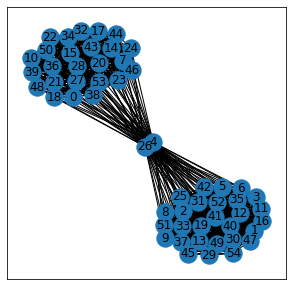

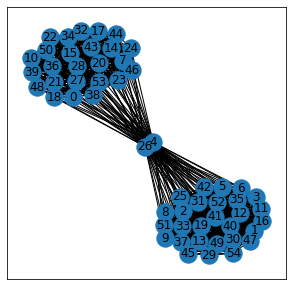

In [31]:
for d in dbscan_outlier_idx:
  if(len(d[2]) > 1 and len(d[2]) < 9):
    print(f"DBSCAN outliers for eps={d[0]} and min_samples={d[1]}:")
    for o in d[2]:
      visualize(G[o[0]])

# Outlier detection with quantiles
The following section finds outliers with a simple statistical method: Data points with multiple dimension below the first or above the third quantile are defined as outliers. The minimum number of dimensions is selected arbitrarily to get the desired number of outliers.

In [32]:
def get_quantiles_and_outliers(vec_rep, num_dims):
  quantiles_75 = np.asarray([np.quantile(col.toarray(), 0.75) for col in vec_rep.T])
  quantiles_25 = np.asarray([np.quantile(col.toarray(), 0.25) for col in vec_rep.T])
  outlier_idx = []

  for i, vec in enumerate(vec_rep):
    greater = (vec > quantiles_75) * 1
    smaller = (vec < quantiles_25) * 1
    if greater.sum() + smaller.sum() >= num_dims:
      outlier_idx.append(i)

  return outlier_idx, quantiles_75, quantiles_25

In [33]:
graphlet_outlier_idx, quantiles_75, quantiles_25 = get_quantiles_and_outliers(vec_graphlet, 2)
print(f"Number of outliers in the graphlet representation: {len(graphlet_outlier_idx)}")

shortestpath_outlier_idx, quantiles_75, quantiles_25 = get_quantiles_and_outliers(vec_shortestpath, 2)
print(f"Number of outliers in the shortestpath representation: {len(shortestpath_outlier_idx)}")

wl_outlier_idx = [0] * 5
for i in range(5):
  wl_outlier_idx[i], quantiles_75, quantiles_25 = get_quantiles_and_outliers(vec_wl[i], 10)
  print(f"Number of outliers in the WL{i+1} representation: {len(wl_outlier_idx[i])}")

overall_outliers = list(set(graphlet_outlier_idx).intersection(set(shortestpath_outlier_idx), set(wl_outlier_idx[0]), set(wl_outlier_idx[1]), set(wl_outlier_idx[2]), set(wl_outlier_idx[3]), set(wl_outlier_idx[4])))
print(f"Number of graphs which are outliers in all representations: {len(overall_outliers)}")

Number of outliers in the graphlet representation: 278
Number of outliers in the shortestpath representation: 265
Number of outliers in the WL1 representation: 17
Number of outliers in the WL2 representation: 208
Number of outliers in the WL3 representation: 494
Number of outliers in the WL4 representation: 827
Number of outliers in the WL5 representation: 861
Number of graphs which are outliers in all representations: 15


Below, you can see those graphs which were selected as outliers in all vector representations. Similar to the outliers found by DBSCAN, these graphs seem to be have more interconnections and a more complex structure than the typical ego-graphs shown in the section "Comparing kernels".

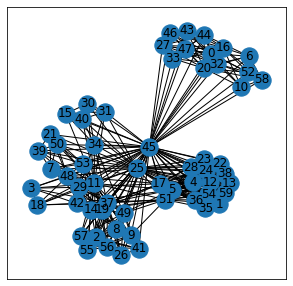

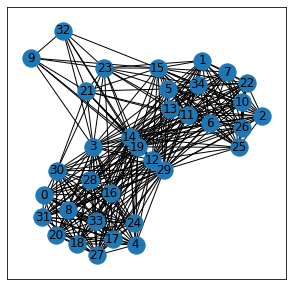

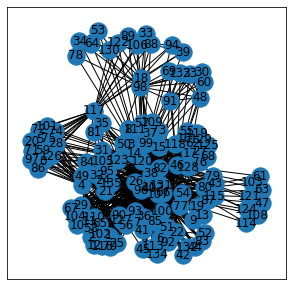

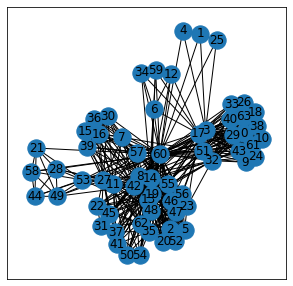

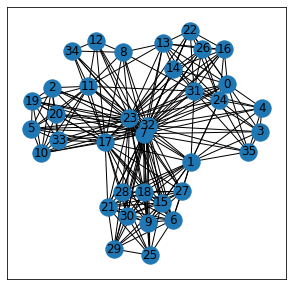

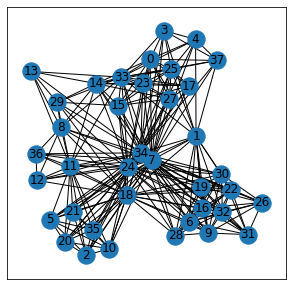

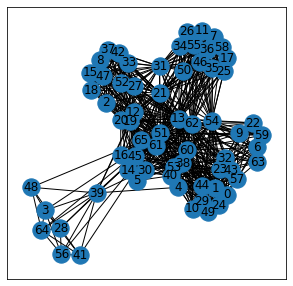

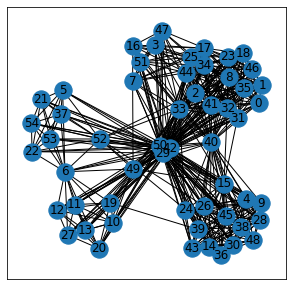

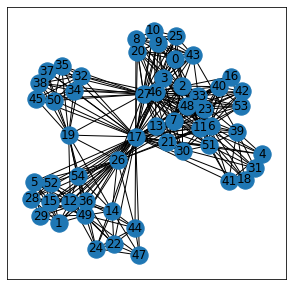

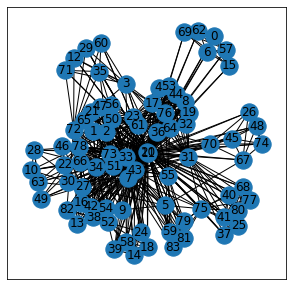

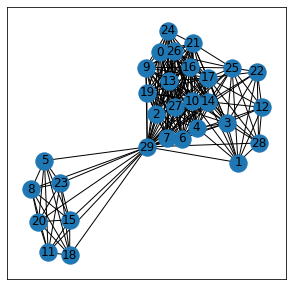

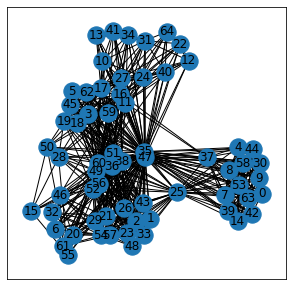

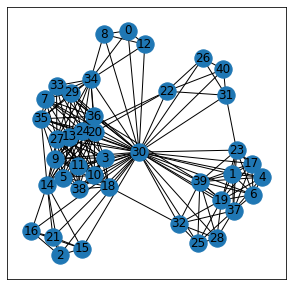

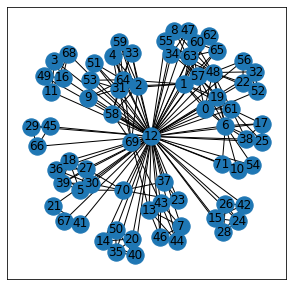

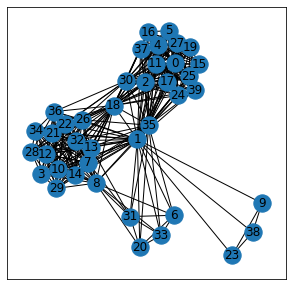

In [34]:
for o in overall_outliers:
  visualize(G[o])